## Import Stuff

In [2]:
import torch
import clip

In [105]:
import numpy as np

In [3]:
from PIL import Image
%matplotlib inline
from matplotlib import pyplot as plt

In [64]:
import inspect
import functools
import os

## Load model

In [8]:
model, preprocessor = clip.load("ViT-B/32", device="cpu")

### How did the load do it?

In [13]:
print(inspect.getsource(clip.load))

def load(name: str, device: Union[str, torch.device] = "cuda" if torch.cuda.is_available() else "cpu", jit: bool = False, download_root: str = None):
    """Load a CLIP model

    Parameters
    ----------
    name : str
        A model name listed by `clip.available_models()`, or the path to a model checkpoint containing the state_dict

    device : Union[str, torch.device]
        The device to put the loaded model

    jit : bool
        Whether to load the optimized JIT model or more hackable non-JIT model (default).

    download_root: str
        path to download the model files; by default, it uses "~/.cache/clip"

    Returns
    -------
    model : torch.nn.Module
        The CLIP model

    preprocess : Callable[[PIL.Image], torch.Tensor]
        A torchvision transform that converts a PIL image into a tensor that the returned model can take as its input
    """
    if name in _MODELS:
        model_path = _download(_MODELS[name], download_root or os.path.expanduser("~/.cache

### What's in the model?

In [10]:
model.visual

VisionTransformer(
  (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
  (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): Sequential(
      (0): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): QuickGELU()
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (1): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise

In [11]:
model.transformer

Transformer(
  (resblocks): Sequential(
    (0): ResidualAttentionBlock(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (c_fc): Linear(in_features=512, out_features=2048, bias=True)
        (gelu): QuickGELU()
        (c_proj): Linear(in_features=2048, out_features=512, bias=True)
      )
      (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (1): ResidualAttentionBlock(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (c_fc): Linear(in_features=512, out_features=2048, bias=True)
        (gelu): QuickGELU()
        (c_proj): Linear(in_features=2048, out_features=512, bias=True)
      

### What's in the preprocessor

In [16]:
preprocessor

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x30b7e62a0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

### Dtype, sizes, etc.

In [14]:
model.dtype

torch.float32

In [29]:
size = 0
for param in model.parameters():
    size += param.numel()
print("number of parameters", size)
print("number of parameters in millions {}".format(size/1e6))

number of parameters 151277313
number of parameters in millions 151.277313


In [32]:
model.visual.input_resolution

224

## Process an Image

In [37]:
image_path = "cow.jpg"

In [38]:
image = Image.open(image_path).convert("RGB")

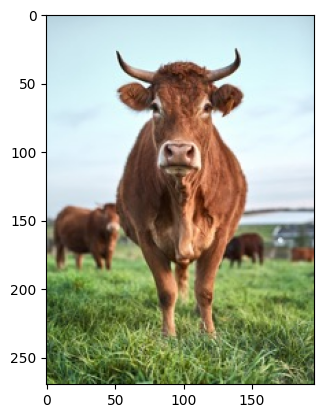

In [39]:
plt.imshow(image)
plt.show()

### Step 1. Preprocess the image

In [41]:
image_tensor = preprocessor(image)

In [42]:
image_tensor.shape

torch.Size([3, 224, 224])

### Step 2. Compute image features

In [44]:
image_features = model.encode_image(image_tensor.unsqueeze(0))

In [49]:
image_features.shape

torch.Size([1, 512])

### What's happening inside?

In [50]:
image_features_raw = model.visual(image_tensor.unsqueeze(0))

In [51]:
image_features_raw.shape

torch.Size([1, 512])

In [52]:
print(inspect.getsource(model.encode_image))

    def encode_image(self, image):
        return self.visual(image.type(self.dtype))



In [54]:
model.dtype

torch.float32

## Process some text

### Let's tokenize

In [48]:
some_classes = ["a cow", "a goat", "a dog"]

In [57]:
tokens = clip.tokenize(some_classes)

In [59]:
tokens

tensor([[49406,   320,  9706, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406,   320,  9530, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 

### How did we tokenize?

In [61]:
from clip.simple_tokenizer import SimpleTokenizer

In [62]:
print(inspect.getsource(SimpleTokenizer.__init__))

    def __init__(self, bpe_path: str = default_bpe()):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

In [67]:
tokenizer = SimpleTokenizer(os.path.join(clip.__path__[0], "bpe_simple_vocab_16e6.txt.gz"))

In [69]:
len(tokenizer.encoder.keys())

49408

In [71]:
print(list(tokenizer.encoder.keys())[:50])

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R']


In [72]:
print(list(tokenizer.encoder.keys())[1000:1050])

['sel', 'ï¸ı</w>', 'world</w>', 'ves</w>', 'cam', 'got</w>', 'inter', 'off</w>', 'um</w>', 'tonight</w>', 'other</w>', 'hou', 'look</w>', 'je', 'id</w>', 'sion</w>', 'beau', 'att', 'eli', 'ort</w>', 'rec', 'ff', 'ster', 'supp', 'gen', 'been</w>', 'ily</w>', 'team</w>', 'mm', 'ic</w>', 'peop', 'itt', 'ats</w>', 'only</w>', 'mber</w>', 'eng', 'bri', 'mp', 'know</w>', 'bur', 'bar', 'ins</w>', 'low</w>', 'she</w>', 'row</w>', 'âĿ', 'tro', 'people</w>', 'via</w>', 'low']


### Let's encode the tokens now.

In [74]:
text_features = model.encode_text(tokens)

In [76]:
text_features.shape

torch.Size([3, 512])

### And how did that work?

In [78]:
print(inspect.getsource(model.encode_text))

    def encode_text(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x



### What's in the embedding?

In [81]:
model.token_embedding

Embedding(49408, 512)

In [84]:
print(inspect.getsource(torch.nn.Embedding.__init__))

    def __init__(
        self,
        num_embeddings: int,
        embedding_dim: int,
        padding_idx: Optional[int] = None,
        max_norm: Optional[float] = None,
        norm_type: float = 2.0,
        scale_grad_by_freq: bool = False,
        sparse: bool = False,
        _weight: Optional[Tensor] = None,
        _freeze: bool = False,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        if padding_idx is not None:
            if padding_idx > 0:
                assert (
                    padding_idx < self.num_embeddings
                ), "Padding_idx must be within num_embeddings"
            elif padding_idx < 0:
                assert (
                    padding_idx >= -self.num_embeddings
                ), "Padding_idx must be within num_embeddings"
                padding_idx = 

In [89]:
print(inspect.getsource(torch.nn.functional.embedding))

def embedding(
    input: Tensor,
    weight: Tensor,
    padding_idx: Optional[int] = None,
    max_norm: Optional[float] = None,
    norm_type: float = 2.0,
    scale_grad_by_freq: bool = False,
    sparse: bool = False,
) -> Tensor:
    r"""Generate a simple lookup table that looks up embeddings in a fixed dictionary and size.

    This module is often used to retrieve word embeddings using indices.
    The input to the module is a list of indices, and the embedding matrix,
    and the output is the corresponding word embeddings.

    See :class:`torch.nn.Embedding` for more details.

    .. note::
        Note that the analytical gradients of this function with respect to
        entries in :attr:`weight` at the row specified by :attr:`padding_idx`
        are expected to differ from the numerical ones.

    .. note::
        Note that `:class:`torch.nn.Embedding` differs from this function in
        that it initializes the row of :attr:`weight` specified by
        :attr:`padding

## Typing the text and image features together... Going multimodal

###  How do we measure distance (or similarity)

In [92]:
def mean_squared_distance(v1, v2):
    return ((v1 - v2)**2).sum()

In [93]:
def cosine_distance(v1, v2):
    eps = 1e-8
    v1 = v1 / (v1.dot(v1).sqrt() + eps)
    v2 = v2 / (v2.dot(v2).sqrt() + eps)
    return 1 - v1.dot(v2)
    

In [94]:
### Let's see them in action

In [95]:
image_features.shape, text_features.shape

(torch.Size([1, 512]), torch.Size([3, 512]))

In [98]:
dist_mse = [mean_squared_distance(image_features[0], text_item_features).item() for text_item_features in text_features]
dist_mse

[157.63670349121094, 192.01803588867188, 195.63804626464844]

In [101]:
dist_cos = [cosine_distance(image_features[0], text_item_features).item() for text_item_features in text_features]
dist_cos

[0.7009309530258179, 0.764248788356781, 0.7900635004043579]

### Finally.. we can classify the image

In [106]:
some_classes[np.argmin(dist_mse)]

'a cow'

In [107]:
some_classes[np.argmin(dist_cos)]

'a cow'